# Regression

Here we'll create our own function for k-fold cross-validation, perform OLS, Lasso, Ridge regression, and regression with Elastic Net. We'll also generate residual plots, pairwise plots, QQ plots, and test some assumptions of regression. This notebook should serve as a quick and basic reference for regression in Python.

## K-Fold Cross Validation

K-Fold cross-validation is fairly trivial to perform, and there exist methods to perform cross-validation in scikit-learn, but let's define a function to demonstrate how it works.

In [57]:
import numpy as np
import sklearn as skl
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [58]:
def kfold_cv_lm(X, y, which_betas, k=10, seed=None):
    """
    Fits an OLS regression model using k-fold cross validation.
    
    Args:
        X (numpy.array): n x p design matrix
        y (numpy.array): n x 1 numeric response
        which_betas (numpy.array, list): p x 1 logical specifying which
            predictors to be included in a regression
        seed (int, None): numeric value to seed the random number
            generator.
            
    Returns:
        (tuple): A tuple of (Avg. MPSE for test data,
            Avg. MSE for training data).
    """
    np.random.seed(seed)
    # Only use X columns specified by the which_betas parameter
    X = X[:, which_betas]
    # Create folds
    sampler = np.arange(y.shape[0]) 
    np.random.shuffle(sampler)
    folds = np.array_split(sampler, k)
    # Perform linear regression using folds
    mse = np.zeros(k, dtype=float)
    mspe = np.zeros(k, dtype=float)
    for i in range(len(folds)):
        # Split training and test data
        train_indx = np.concatenate(folds[:i] + folds[(i + 1):])
        test_indx = folds[i]
        train_X, train_y = (X[train_indx, :], y[train_indx])
        test_X, test_y = (X[test_indx, :], y[test_indx])
        # Fit the model
        ols = linear_model.LinearRegression()
        ols.fit(train_X, train_y)
        # Get MSE of training set
        y_pred_train = ols.predict(train_X)
        mse[i] = mean_squared_error(train_y, y_pred_train)
        # Get MSPE of test set
        y_pred_test = ols.predict(test_X)
        mspe[i] = mean_squared_error(test_y, y_pred_test)
    return mspe.mean(), mse.mean()

### Testing the Function

Let's load some fake data to run through our new function `kfold_cv_lm()`.

In [59]:
from sklearn import datasets
boston = datasets.load_boston()
print boston.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [60]:
X = boston.data
y = boston.target
print X.shape
print y.shape

(506, 13)
(506,)


In [61]:
X[0:3, :]

array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00,
          0.00000000e+00,   5.38000000e-01,   6.57500000e+00,
          6.52000000e+01,   4.09000000e+00,   1.00000000e+00,
          2.96000000e+02,   1.53000000e+01,   3.96900000e+02,
          4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00,
          0.00000000e+00,   4.69000000e-01,   6.42100000e+00,
          7.89000000e+01,   4.96710000e+00,   2.00000000e+00,
          2.42000000e+02,   1.78000000e+01,   3.96900000e+02,
          9.14000000e+00],
       [  2.72900000e-02,   0.00000000e+00,   7.07000000e+00,
          0.00000000e+00,   4.69000000e-01,   7.18500000e+00,
          6.11000000e+01,   4.96710000e+00,   2.00000000e+00,
          2.42000000e+02,   1.78000000e+01,   3.92830000e+02,
          4.03000000e+00]])

In [62]:
y[0:3]

array([ 24. ,  21.6,  34.7])

In [63]:
# Remove the boolean dummy variable CHAS
which_betas = np.ones(13, dtype=bool)
which_betas[3] = False
which_betas

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [64]:
kfold_cv_lm(X, y, which_betas)

(23.68070811742848, 22.263358733744646)

Above are our average MSE and MSPE (mean-squared prediction error) for the Boston data set using 10 fold cross-validation. That was easy, wasn't it?

## Testing Multiple Regression Models

Let's use a different data set to explore various regression models. We should explore how OLS performs with various betas (from _p_ = 1 to the full model), and use Ride, Lasso, and Elastic Net to penalize (or eliminate) predictors that display collinearity or are not correlated to the target.

### Load the Data

The data captures various data that could be useful in predicting room and board costs at universities around the country. Predictors include the acceptance rate of the university, out-of-state tuition, whether or not the school is public or private, etc.

In [65]:
import requests
from io import StringIO

In [66]:
r = requests.get("http://www-bcf.usc.edu/~gareth/ISL/College.csv")
s = StringIO(r.text)
college = np.recfromtxt(s, delimiter=",", skip_header=True, dtype=[
        ("school", '|S200'), ("private", '|S3'), ("apps", 'i32'),
        ("accept", 'i32'), ("enroll", 'i32'),
        ("top10perc", 'i32'), ("top25perc", 'i32'),
        ("f_undergrad", 'i32'), ("p_undergrad", 'i32'),
        ("outstate", 'i32'), ("room_board", 'i32'),
        ("books", 'i32'), ("personal", 'i32'), ("phd", 'i32'),
        ("terminal", 'i32'), ("s_f_ratio", 'd32'),
        ("perc_alumni", 'i32'), ("expend", 'i32'),
        ("grad_rate", 'i32')])

In [67]:
college[0] # college is a Numpy recarray, so this is first row.
           # A recarray is required to have an array with columns
           # of different type. Alternatively, we could use a Pandas
           # data frame instead of Numpy.

('Abilene Christian University', 'Yes', 1660, 1232, 721, 23, 52, 2885, 537, 7440, 3300, 450, 2200, 70, 78, 18.1, 12, 7041, 60)

In [68]:
college.dtype.fields  # Columns (in alphabetical order). Actual
                      # order is irrelevant since each column is
                      # accessed with dot notation (college.col_name)
                      # with recarrays.

<dictproxy {'accept': (dtype('int32'), 207),
 'apps': (dtype('int32'), 203),
 'books': (dtype('int32'), 239),
 'enroll': (dtype('int32'), 211),
 'expend': (dtype('int32'), 267),
 'f_undergrad': (dtype('int32'), 223),
 'grad_rate': (dtype('int32'), 271),
 'outstate': (dtype('int32'), 231),
 'p_undergrad': (dtype('int32'), 227),
 'perc_alumni': (dtype('int32'), 263),
 'personal': (dtype('int32'), 243),
 'phd': (dtype('int32'), 247),
 'private': (dtype('S3'), 200),
 'room_board': (dtype('int32'), 235),
 's_f_ratio': (dtype('float64'), 255),
 'school': (dtype('S200'), 0),
 'terminal': (dtype('int32'), 251),
 'top10perc': (dtype('int32'), 215),
 'top25perc': (dtype('int32'), 219)}>

In [69]:
college.shape  # Just returns number of rows since it's a recarray

(777,)

### Extract Five Potentially Important Predictors and Target

In [70]:
# Here we need column_stack() rather than hstack() to turn the
# 1D arrays into 2D.
data = np.column_stack(
    (college.accept,
     college.enroll,
     college.outstate,
     college.books,
     college.grad_rate,
     college.room_board)
)

In [71]:
data.shape

(777, 6)

In [72]:
data

array([[ 1232,   721,  7440,   450,    60,  3300],
       [ 1924,   512, 12280,   750,    56,  6450],
       [ 1097,   336, 11250,   400,    54,  3750],
       ..., 
       [ 1915,   695,  6900,   617,    49,  4200],
       [ 2453,  1317, 19840,   630,    99,  6510],
       [ 1855,   691,  4990,   500,    99,  3560]], dtype=int32)

### Plot Pairwise Scatterplot of Predictors

In [73]:
import pandas as pd
import seaborn as sns  # Will change matplotlib's default colors
                       # to something more aesthetically pleasing.
%matplotlib inline

In [74]:
df = pd.DataFrame(data, columns=["accept", "enroll", "outstate",
                                 "books", "grad_rate", "room_board"])

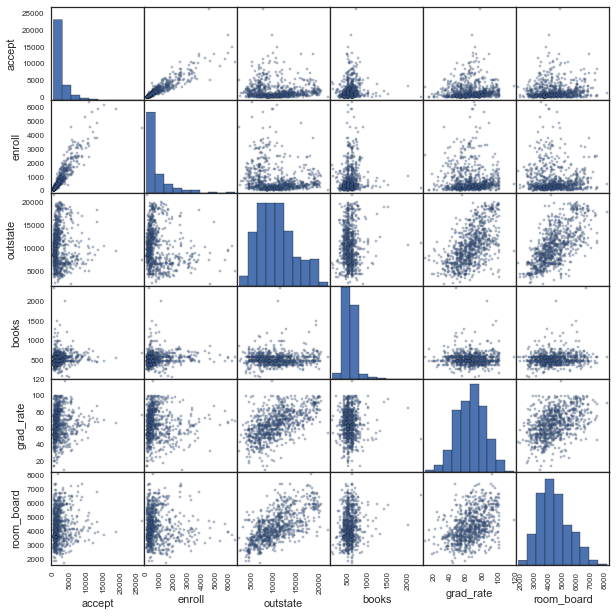

In [75]:
sns.set_style("white")  # Set plot style
sns.set_context("notebook")  # Set font size of plots
axes = pd.tools.plotting.scatter_matrix(df,
                                        figsize=(10, 10),
                                        alpha=0.4,
                                        diagonal='hist')

Note: the histograms correspond to column variables.

#### Observations About Predictors
There are some expected trends, such as number of enrollments increasing with acceptance rate. The cost of books seems relatively unrelated to the other predictors. The graduation rate doesn't seem to be related to acceptance rate, but rather it is proportionally related to out-of-state tuition. It also seems that out-of-state tuition is not related to total enrollments - instead it seems like it is a fixed number for the universities.

#### Observations About Predictor Relationship to Room and Board
Room and board cost, expectedly, seems unrelated to enrollment rate and acceptance rate. It appears to be most correlated with out of state tuition and graduation rate. It also appears uncorrelated with the cost of books.

There is a lot you could try to explore about these observations. For example, does the room and board positive correlation with graduation rate indicate that schools that graduate more students are in more expensive areas in the country, or are those schools charging more for the same cost of living? From a statistical point of view, there seems to be collinearity between enrollment and acceptance rate, which we might be wary of when using OLS regression.

### Run OLS Regression On All Possible Models

We have pulled out five features to try to predict our target. While they all might be important, we also want to see if a certain combination of predictors performs better than another.

In [76]:
from itertools import product

In [77]:
# Create all possible combinations of predictors (2^5 = 32)
predictor_combos = product([0, 1], repeat=5)
# (0, 0, 0, 0, 0)
# (0, 0, 0, 0, 1)
# (0, 0, 0, 1, 0)
# (0, 0, 0, 1, 1)
# ...etc

`predictor_combos` is a logical vector that we can pass to our `kfold_cv_lm` function to determine which betas to use for OLS regression.

In [78]:
X = data[:, 0:5]
y = data[:, -1]
print X.shape, y.shape

(777, 5) (777,)


In [79]:
all_mse = []  # Will be list of sublists where each sublist contains
              # all the MSEs for 100 runs of 10-fold CV for the same
              # group of betas.
all_mspe = []  # Same as above
betas = []
for num, combos in enumerate(predictor_combos):
    # Need to ignore (0, 0, 0, 0, 0)
    if num != 0:
        which_betas = np.array(combos, dtype=bool)
        betas.append(which_betas)
        mses = []
        mspes = []
        for i in range(100):
            # Run k-fold CV on each model 100 times to get
            # distribution of MSEs/MSPEs for each combo of betas
            mspe, mse = kfold_cv_lm(X, y, which_betas)
            mses.append(mse)
            mspes.append(mspe)
        all_mse.append(mses)
        all_mspe.append(mspes)

In [80]:
len(all_mspe)

31

So there are 31 lists, each containing 100 MSPEs from 100 different runs of 10-fold CV. We can choose a model by finding the minimum average (average) MSPE. (Since we're dealing with k-folds, all the MSE/MSPE returned by that function are already averages of MSPE for each fold).

In [81]:
mean_mses = [np.array(mse_distrib).mean()
             for mse_distrib in all_mse]
mean_mspes = [np.array(mspe_distrib).mean()
              for mspe_distrib in all_mspe]
mean_mses, mean_mspes = (np.array(mean_mses), np.array(mean_mspes))
mean_mspes

array([  989501.25361319,  1187660.22091025,   973715.08079749,
         690838.87635138,   687685.96013275,   680784.25324252,
         677560.77518241,  1205200.8202662 ,   990893.41125522,
        1186412.35279345,   973259.42559919,   687653.02627002,
         685686.6984126 ,   679236.6991091 ,   676804.80221746,
        1197567.22738571,   988317.41602554,  1183584.64297681,
         974270.10388872,   678410.07169803,   677634.66312392,
         671045.81077184,   669183.95650467,  1122733.35492104,
         952922.99690402,  1107401.21186131,   936023.33389003,
         673610.73215409,   671961.55290547,   665453.29634578,
         663840.07969275])

Now we have 31 average MSEs and MSPEs, each representing models from a single combination of betas. The minimum MSPE will indicate which model performed best.

In [82]:
mean_mspes.argmin()

30

In [83]:
mean_mses.argmin()

30

MSE also is lowest at the lowest MSPE. So our chosen model is the 30th model.

In [84]:
betas[30]

array([ True,  True,  True,  True,  True], dtype=bool)

We can see that the chosen model is the full model. We'll plot the histogram of the MSE and MSPE for that model after looking at the parameter estimates.

### Parameter Estimates and Standard Errors

Using the full model, let's train on the entire data set now to get the parameter estimates.

In [85]:
ols = linear_model.LinearRegression()
ols.fit(X, y)
param_estimates = ols.coef_
intercept = np.array([ols.intercept_])
param_estimates = np.concatenate((intercept, param_estimates))
cols = ["_intercept", "accept", "enroll", "outstate", "books",
        "grad_rate"]

In [86]:
results = {'Coeff': pd.Series(param_estimates, index=cols)}
df = pd.DataFrame(results)
print df

                  Coeff
_intercept  2013.448038
accept         0.140885
enroll        -0.290489
outstate       0.158986
books          0.645821
grad_rate      4.147484


We have to calculate the standard errors of the parameter estimates ourselves since there is no function in scikit-learn to retrieve these values. Or, we could be somewhat more resourceful and generate a linear model using a package that provides some more statistical utility (scikit-learn is great for machine learning, confusion matrices, ROC curves, etc., but not for stats). We could use Numpy's *linalg.lstsq* function, which has a method to return the residuals, but we want a bit more info than that. So let's move to the StatsModels package, which has methods and summaries similar to what we might see in R.

In [87]:
import statsmodels.api as sm
X_with_constant = sm.add_constant(X)
# The model needs an intercept so add a column of 1's
statsmodel_ols = sm.OLS(y, X_with_constant)
model = statsmodel_ols.fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     131.4
Date:                Fri, 20 Nov 2015   Prob (F-statistic):          1.12e-100
Time:                        16:26:27   Log-Likelihood:                -6301.6
No. Observations:                 777   AIC:                         1.262e+04
Df Residuals:                     771   BIC:                         1.264e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       2013.4480    153.223     13.141      0.0

Above, we can see that the parameter estimates match what we got with scikit-learn, and we can also see the standard errors of the parameters. Later, if I have time, I'll calculate the standard errors of the parameters by hand using the model built by scikit-learn to compare with the results from the StatsModels package.

Notice the warning at the bottom of the summary about possible multicollinearity. This is to be expected, since when we made the pairwise plots we saw strong correlation between acceptance rate and enrollment rate. We'd probably want to do something about this in the real world.

#### Interpretation

The fifth variable, _x5_ (graduation rate), stands out amongst all other variables. It's standard error of $2.071$ is relatively high compared to the standard errors of the other predictors. The standard error tells us, roughly, on average how far away our predictions are from the true values using this predictor. This is an indication that this variable might not be a great predictor of true values. The p-value for _x5_ also stands out. Here, a low p-value (e.g. < 0.05) indicates that we can reject the null hypothesis of the regression analysis for this variable, which is that the predictor has no effect on prediction. If the p-value is less than 0.05, it is common to consider the variable/coefficient to be significant.

### Histogram of MSE/MSPE from 100 10-Fold CV Runs

In [88]:
import pylab as p

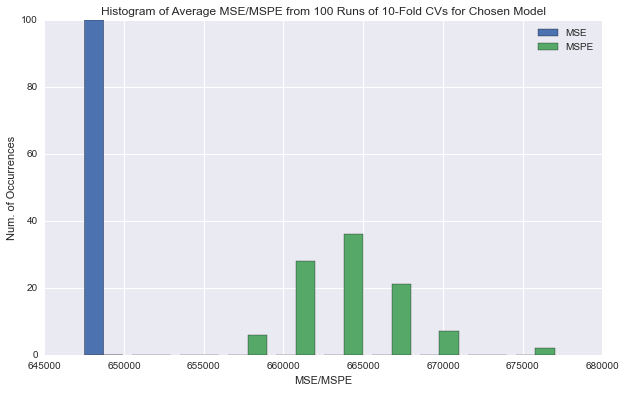

In [89]:
# Extract the 100 MSEs and 100 MSPEs for the chosen model
chosen_mse = all_mse[30]
chosen_mspe = all_mspe[30]
errors = np.column_stack((chosen_mse, chosen_mspe))
# Plot the histogram
sns.set_style("darkgrid")
p.figure(figsize=(10, 6))
n, bins, patches = p.hist(errors, 10, histtype='bar',
                         label=["MSE", "MSPE"])
p.legend()
p.title("Histogram of Average MSE/MSPE from 100 Runs of 10-Fold CVs for Chosen Model")
p.xlabel("MSE/MSPE")
p.ylabel("Num. of Occurrences")

### Model Selection Based on Adjusted R-Squared

R<sup>2</sup> is often used as the criterion for model selection for regression. However, R<sup>2</sup> has several drawbacks, one of which is that as you increase the number of predictors in your model R<sup>2</sup> will tend to go up regardless of whether or not your predictions are actually improving. This is because R<sup>2</sup> is a measurement of error on your training set; using MSPE for your selection criterion is one way to avoid this issue. Another is to use adjusted R<sup>2</sup>, which penalizes R as the number of predictors increases.

In [90]:
from IPython.display import Latex
from sklearn.metrics import r2_score

In order to retrieve adjusted R<sup>2</sup> values during cross-validation, we have to modify our original function to return them. Since Scikit-learn does not have a function for getting adjusted R<sup>2</sup> (but does for R<sup>2</sup>), we will have to calculate it ourselves after the model is fit. The easiest way to do this is to calculate adjusted R<sup>2</sup> in terms of R<sup>2</sup>.

$$R^2_{adj} = 1 - (1 - R^2) * \frac{(n - 1)}{(n - p - 1)}$$

In [91]:
def kfold_cv_lm_r2adj(X, y, which_betas, k=10, seed=None):
    """
    Fits an OLS regression model using k-fold cross validation.
    
    Args:
        X (numpy.array): n x p design matrix
        y (numpy.array): n x 1 numeric response
        which_betas (numpy.array, list): p x 1 logical specifying which
            predictors to be included in a regression
        seed (int, None): numeric value to seed the random number
            generator.
            
    Returns:
        (float): Adjusted R^2.
    """
    np.random.seed(seed)
    # Only use X columns specified by the which_betas parameter
    X = X[:, which_betas]
    # Create folds
    sampler = np.arange(y.shape[0]) 
    np.random.shuffle(sampler)
    folds = np.array_split(sampler, k)
    # Perform linear regression using folds
    r_squared_adj = np.zeros(k, dtype=float)
    for i in range(len(folds)):
        # Split training and test data
        train_indx = np.concatenate(folds[:i] + folds[(i + 1):])
        test_indx = folds[i]
        train_X, train_y = (X[train_indx, :], y[train_indx])
        test_X, test_y = (X[test_indx, :], y[test_indx])
        # Fit the model
        ols = linear_model.LinearRegression()
        ols.fit(train_X, train_y)
        ##################################################
        ############# CALCULATE ADJUSTED R^2 #############
        ##################################################
        # Get R^2 of model
        y_pred_train = ols.predict(train_X)
        r_squared = r2_score(train_y, y_pred_train)
        # Calculate adjusted R^2
        n = X.shape[0]
        p = sum(which_betas)
        r2_adj = 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))
        r_squared_adj[i] = r2_adj
    return r_squared_adj.mean()

Now we can get adjusted R<sup>2</sup> for all the combinations of betas we used before. In many cases we'd want to use the same folds that we did in the previous estimation (and in fact we can: if we stored every model that we ran before we could simply compute adjusted R<sup>2</sup>), but another 100 runs of 10-fold CV should give us similar enough results that we will be safe comparing to previous results. So let's just run CV again, this time using adjusted R<sup>2</sup> as our assessment criterion.

In [92]:
predictor_combos = product([0, 1], repeat=5)
all_r2_adj = []  # Will be list of sublists where each sublist
                 # contains all the R^2 for 100 runs of 10-fold CV
                 # for the same group of betas.
betas = []
for num, combos in enumerate(predictor_combos):
    # Need to ignore (0, 0, 0, 0, 0)
    if num != 0:
        which_betas = np.array(combos, dtype=bool)
        betas.append(which_betas)
        r2_adjs = []
        for i in range(100):
            # Run k-fold CV on each model 100 times to get
            # distribution of adjusted R^2 for each combo of betas
            r2_adj = kfold_cv_lm_r2adj(X, y, which_betas)
            r2_adjs.append(r2_adj)
        all_r2_adj.append(r2_adjs)

In [93]:
len(all_r2_adj)

31

In [94]:
mean_r2_adjs = [np.array(r2_adj_distrib).mean()
                for r2_adj_distrib in all_r2_adj]

In [95]:
np.argmax(mean_r2_adjs)

30

Using adjusted R<sup>2</sup> we get the same model as we did with MSPE (the full model).

### Testing Normal Assumptions of Chosen Model

There are several assumptions that linear regression makes: no collinearity, no outliers, etc. We already detected a bit of collinearity, so we can test that assumption. We can use the same data frame we used to generate the pairwise plots earlier.

In [96]:
import matplotlib.pyplot as plt
df = pd.DataFrame(data, columns=["accept", "enroll", "outstate",
                                 "books", "grad_rate", "room_board"])
print df.corr()

              accept    enroll  outstate     books  grad_rate  room_board
accept      1.000000  0.911637 -0.025755  0.113525   0.067313    0.090899
enroll      0.911637  1.000000 -0.155477  0.112711  -0.022341   -0.040232
outstate   -0.025755 -0.155477  1.000000  0.038855   0.571290    0.654256
books       0.113525  0.112711  0.038855  1.000000   0.001061    0.127963
grad_rate   0.067313 -0.022341  0.571290  0.001061   1.000000    0.424942
room_board  0.090899 -0.040232  0.654256  0.127963   0.424942    1.000000


We see a correlation of 0.91 between *accept* and *enroll*, so the assumption of no collinearity can be considered violated in our full model.

We can also consider the residual plot to assess for heteroskedasicity. We'll use our scikit-learn model for convenience.

While R's `lm` function provides convenient functions for plotting residuals, with Python and scikit-learn we need to calculate and plot the residuals ourselves. Let's do that.

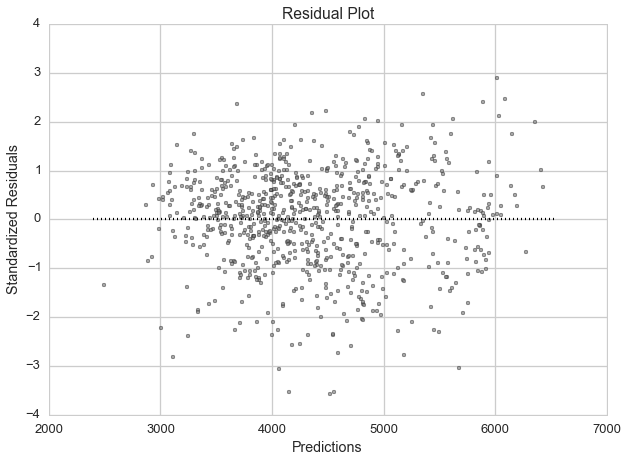

In [97]:
sns.set_context("talk")  # Increase font size on plot
predictions = ols.predict(X)
resids = predictions - y  # Residuals
standardized_resids = resids / np.std(resids)
fig = plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")
plt.scatter(predictions, standardized_resids, s=14, c='gray',
            alpha=0.7)
plt.hlines(y=0, xmin=predictions.min() - 100,
           xmax=predictions.max() + 100,
          linestyle='dotted')
plt.title("Residual Plot")
plt.xlabel("Predictions")
plt.ylabel("Standardized Residuals")

To check for normality we really want to look at a Q-Q plot (quantile plot) or probability plot.

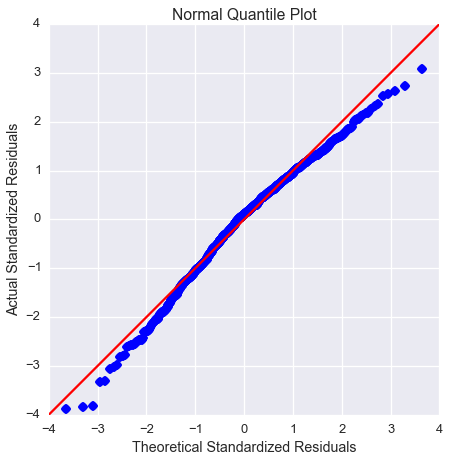

In [98]:
import scipy.stats as stats
residuals = predictions - y
probplot = sm.ProbPlot(resids, stats.t, fit=True)
# qqplot doesn't respont to figure size, so prep a figure
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(7, 7))
probplot.qqplot(line="45", ax=ax)
plt.title("Normal Quantile Plot")
plt.xlabel("Theoretical Standardized Residuals")
plt.ylabel("Actual Standardized Residuals")
plt.show()

If all went well, we should have the correct QQ plot above. The distribution of the prediction errors should be normally distributed in an ideal regression model. The QQ plot compares the error distribution of the residuals to the normal distribution (the red line). We'd like to see a normal distribution, which would be indicated by the points on the QQ plot being aligned with the red line. Here, we see a slight bow, which would indicate some skewness. This is likely coming from the right hand side of the residual plot above, which is more widely distributed vertically than the left half of the residual plot.

We can run traditional statistics tests to assess normality more quantitatively.

In [99]:
from scipy.stats import anderson
a, crit_val, significance = anderson(residuals, dist="norm")
print "Significance levels: {}%".format(significance)
print "Critical Values: {}".format(crit_val)
print "Anderson-Darling: {}".format(a)

Significance levels: [ 15.   10.    5.    2.5   1. ]%
Critical Values: [ 0.573  0.653  0.783  0.913  1.086]
Anderson-Darling: 3.46209918362


The Anderso-Darling test above would indicate that the error terms do not come from a normal distribution since A<sup>2</sup> (3.462) is above all the critical values for every significance level. This combined with the bow in our QQ plot and the skewness in our standardized residuals hints at a violation of normality.

## Ridge Regression

The StatsModels package has a [linear function](http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html) that "closely follows [the implementation] in the _glmnet_ package in R". However, since scikit-learn has convenience functions to perform Ridge and Lasso regression using cross-validation (*RidgeCV* and *LassoCV*) and we really only want to find MSPE of the chosen model, let's use scikit-learn here.

From what I can tell, the [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), and [Elastic Net](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) functions refer to lambda as alpha...or essentially create their own grid of lambdas. I'd have to look into the source code.

In [100]:
# Let's get all 17 predictors now
priv = college.private == "Yes"  # A logical
priv_bool = priv.astype("int")  # Convert to factor
X_full = np.column_stack((
        priv_bool,
        college.apps,
        college.accept,
        college.enroll,
        college.top10perc,
        college.top25perc,
        college.f_undergrad,
        college.p_undergrad,
        college.outstate,
        college.books,
        college.personal,
        college.phd,
        college.terminal,
        college.s_f_ratio,
        college.perc_alumni,
        college.expend,
        college.grad_rate
))
X_full.shape

(777, 17)

Ridge regression applies a penalty term to decrease the effect of certain predictors on predictions. As the penalty (alpha) increases, the beta coefficient for that term tends toward zero, but will not reach exactly zero. We can visualize this regularization of Ridge regression on this data set for a number of different alphas. 

In [101]:
alphas = np.logspace(-1, 7, num=500)
clf = linear_model.Ridge()
coeffs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_full, y)
    coeffs.append(clf.coef_)

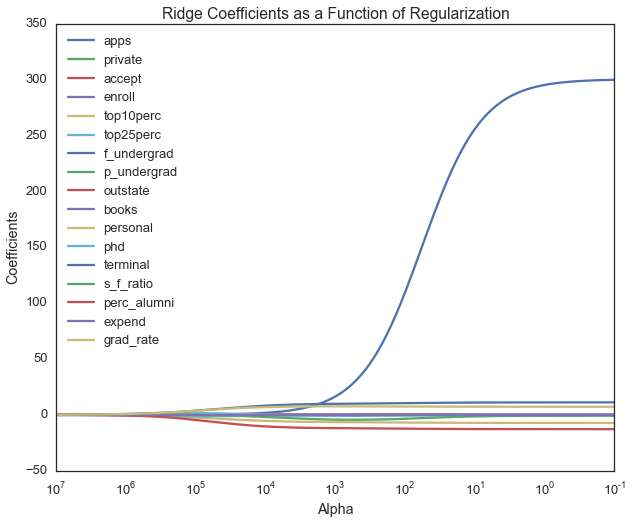

In [102]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10, 8))
lines = ax.plot(alphas, coeffs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.legend(lines,
           ["apps", "private", "accept", "enroll", "top10perc",
            "top25perc", "f_undergrad", "p_undergrad", "outstate",
            "books", "personal", "phd", "terminal", "s_f_ratio",
            "perc_alumni", "expend", "grad_rate"],
           loc="upper left")
plt.title("Ridge Coefficients as a Function of Regularization")
plt.xlabel("Alpha")
plt.ylabel("Coefficients")
plt.show()

All the way at the right of the graph, we see the OLS estimates for the coefficients. As alpha increases, the betas (parameter estimates) have to decrease nearly to zero to counteract the increasing penalty of alpha. Let's now find our ideal alpha using MSPE as our assessment criterion and get the beta coefficients at that value.

Since we're not going to have access to the training and test data after we perform cross-validation to make our model selection, let's hold out part of our data set as test to calculate our MSPE afterward.

In [103]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.20, random_state=1)

In [104]:
alphas = np.logspace(-1, 12, num=20000)
mspes = np.zeros(alphas.shape[0], dtype="float")
coeffs = []
models = []
for i, alpha in enumerate(alphas):
    # We'll override scikit-learn's auto-solver, and instead use
    # "lsqr" to solve with regularized least-squares. Both solvers
    # will produce different results and plots below.
    clf = linear_model.Ridge(alpha=alpha, solver="lsqr")
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    mspes[i] = mean_squared_error(y_test, y_pred_test)
    params = np.concatenate((np.array([clf.intercept_]),
                             clf.coef_))
    coeffs.append(params)
    models.append(clf)

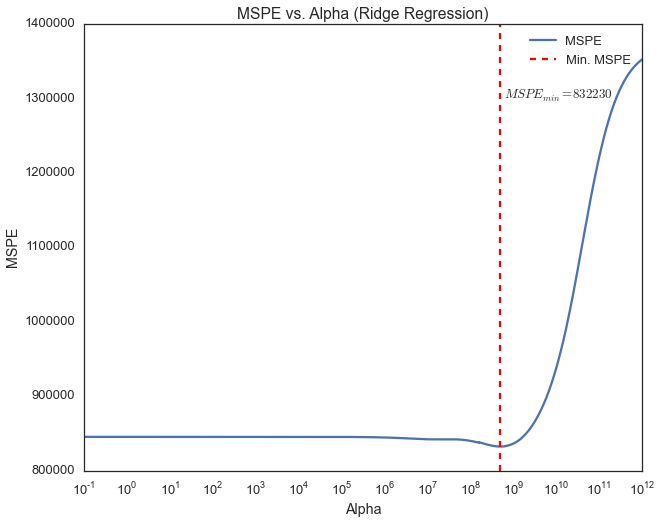

In [105]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(alphas, mspes, label="MSPE")
ax.axvline(x=alphas[mspes.argmin()], c='r', linestyle='dashed',
           label="Min. MSPE")
ax.set_xscale('log')
plt.legend(loc="upper right")
ax.text(alphas[mspes.argmin()] + 100000000,
        1300000,
        r"$MSPE_{{min}} = {:.0f}$".format(mspes.min()),
        fontsize=13)
plt.title("MSPE vs. Alpha (Ridge Regression)")
plt.xlabel("Alpha")
plt.ylabel("MSPE")
plt.show()

In [106]:
# Collect the ridge coefficients for the model to display later
ridge_coeffs = coeffs[mspes.argmin()]
ridge_mspe = mspes.min()
ridge_model = models[mspes.argmin()]

The parameter estimates (beta coefficients) from Ridge regression will be different than those of standard linear regression, but none will be eliminated. Ridge regression does not eliminate paramaters, so we might instead see the effect of some parameters reduced by Ridge when compared with standard regression. We find our ideal alpha by locating the point of minimum MSPE on the graph above.

## Lasso Regression

Let's quickly run the same things using Lasso. Lasso regression is similar to Ridge in that it applies a penalty term. However, unlike Ridge, Lasso has the ability to completely eliminate parameters by setting coefficients to exactly zero.

In [107]:
alphas = np.logspace(-1, 4, num=500)
clf = linear_model.Lasso()
coeffs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_full, y)
    coeffs.append(clf.coef_)

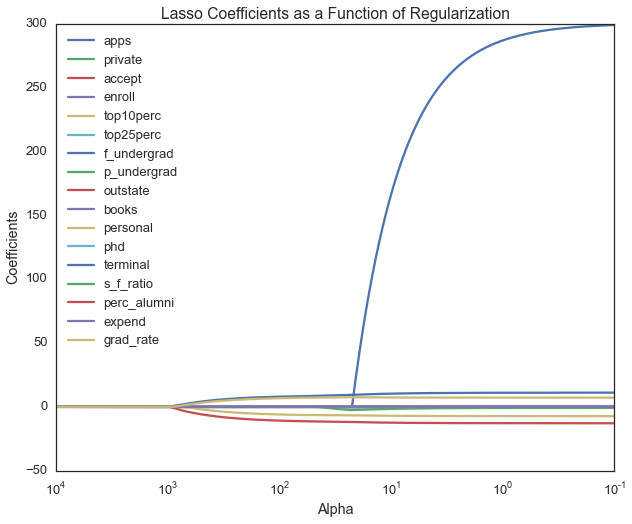

In [108]:
fig, ax = plt.subplots(figsize=(10, 8))
lines = ax.plot(alphas, coeffs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.legend(lines,
           ["apps", "private", "accept", "enroll", "top10perc",
            "top25perc", "f_undergrad", "p_undergrad", "outstate",
            "books", "personal", "phd", "terminal", "s_f_ratio",
            "perc_alumni", "expend", "grad_rate"],
           loc="upper left")
plt.title("Lasso Coefficients as a Function of Regularization")
plt.xlabel("Alpha")
plt.ylabel("Coefficients")
plt.show()

Above, we can see several coefficients reach zero at various alphas.

In [109]:
alphas = np.logspace(-1, 8, num=20000)
mspes = np.zeros(alphas.shape[0], dtype="float")
coeffs = []
models = []
for i, alpha in enumerate(alphas):
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    mspes[i] = mean_squared_error(y_test, y_pred_test)
    params = np.concatenate((np.array([clf.intercept_]),
                             clf.coef_))
    coeffs.append(params)
    models.append(clf)

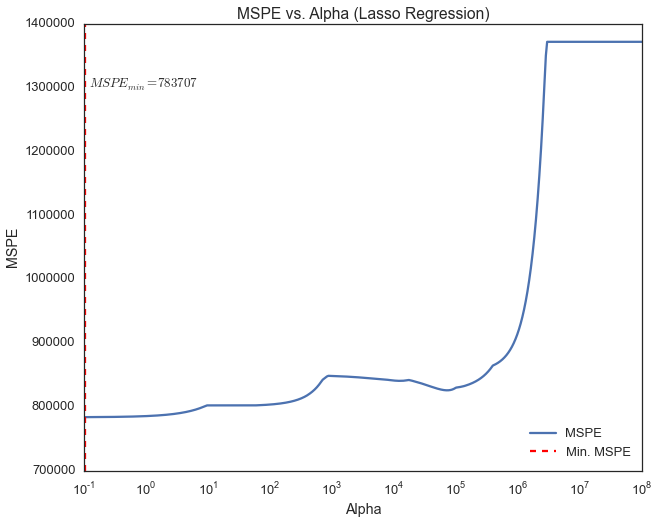

In [110]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(alphas, mspes, label="MSPE")
ax.axvline(x=alphas[mspes.argmin()] + 0.005,
           c='r', linestyle='dashed',
           label="Min. MSPE")
ax.set_xscale('log')
plt.legend(loc="lower right")
ax.text(alphas[mspes.argmin()] + 0.02,
        1300000,
        r"$MSPE_{{min}} = {:.0f}$".format(mspes.min()),
        fontsize=13)
plt.title("MSPE vs. Alpha (Lasso Regression)")
plt.xlabel("Alpha")
plt.ylabel("MSPE")
plt.show()

It looks as if the MSPE's from the Lasso model are indicating that the best MSPE is from the OLS regression model, meaning none of the parameters will be eliminated with our Lasso regression (we'll look at the coefficients later).

In [111]:
# Collect the Lasso coefficients for display later
lasso_coeffs = coeffs[mspes.argmin()]
lasso_mspe = mspes.min()
lasso_model = models[mspes.argmin()]

## Elastic Net

Elastic Net incorporates both penalties, essentially combining Ridge and Lasso regression.

In [112]:
alphas = np.logspace(-1, 8, num=20000)
mspes = np.zeros(alphas.shape[0], dtype="float")
coeffs = []
models = []
for i, alpha in enumerate(alphas):
    clf = linear_model.ElasticNet(alpha=alpha, l1_ratio=0.5)
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    mspes[i] = mean_squared_error(y_test, y_pred_test)
    params = np.concatenate((np.array([clf.intercept_]),
                             clf.coef_))
    coeffs.append(params)
    models.append(clf)

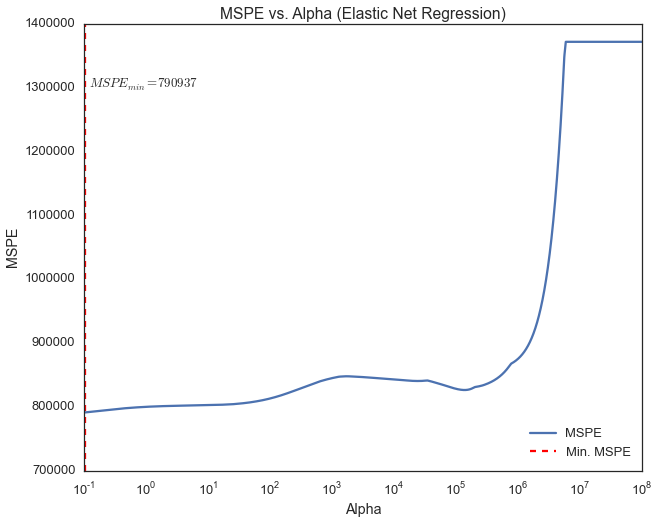

In [113]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(alphas, mspes, label="MSPE")
ax.axvline(x=alphas[mspes.argmin()] + 0.005,
           c='r', linestyle='dashed',
           label="Min. MSPE")
ax.set_xscale('log')
plt.legend(loc="lower right")
ax.text(alphas[mspes.argmin()] + 0.02,
        1300000,
        r"$MSPE_{{min}} = {:.0f}$".format(mspes.min()),
        fontsize=13)
plt.title("MSPE vs. Alpha (Elastic Net Regression)")
plt.xlabel("Alpha")
plt.ylabel("MSPE")
plt.show()

In [114]:
# Collect the Elastic Net coefficients
enet_coeffs = coeffs[mspes.argmin()]
enet_mspe = mspes.min()
enet_model = models[mspes.argmin()]

### Compare Ridge, Lasso, Elastic Net Coefficients

In [115]:
cols = ["_intercept", "private", "apps", "accept", "enroll",
        "top10perc", "top25perc", "f_undergrad", "p_undergrad",
        "outstate", "books", "personal", "phd", "terminal",
        "s_f_ratio", "perc_alumni", "expend", "grad_rate"]
results = {'Ridge Coeff': pd.Series(ridge_coeffs, index=cols),
           'Lasso Coeff': pd.Series(lasso_coeffs, index=cols),
           'Elastic Net': pd.Series(enet_coeffs, index=cols)}
df = pd.DataFrame(results)
print df

             Elastic Net  Lasso Coeff  Ridge Coeff
_intercept   1606.440751  1558.713718  2603.458933
private        77.365144   131.010475     0.000013
apps            0.084098     0.085193     0.049081
accept         -0.035267    -0.037033     0.012659
enroll         -0.247173    -0.245687    -0.022591
top10perc      -9.822516    -9.873752    -0.001011
top25perc       1.719845     1.729894    -0.000725
f_undergrad    -0.006667    -0.004805    -0.038710
p_undergrad     0.096722     0.097007     0.063245
outstate        0.152051     0.149229     0.142297
books           0.691125     0.687762     0.021222
personal       -0.110428    -0.111550    -0.026266
phd            -1.156684    -0.902008     0.000459
terminal        8.713771     8.878668     0.001023
s_f_ratio      -3.074226    -2.406610    -0.000005
perc_alumni   -11.733312   -11.882426    -0.001078
expend          0.024473     0.024697     0.024093
grad_rate       7.158079     7.075702     0.001015


### Comparision

I'm a bit concerned about how the MSPEs of the Lasso and Elastic Net models increased as the penalty multiplier increased. There could be some aspect of overfitting, but I'm leaning more toward unfamiliarity with the Python package and lack of excellent documentation when compared with similar R functions. I'm a bit wary that no terms were eliminated from the Lasso model. From what we know about Ridge, Lasso, and Elastic Net, Lasso is best suited for variable selection/sparse relationship and Ridge is best suited for ill-conditioned problems. Since we saw some colinearity in our first pairwise plot, this is an ill-conditioned data set, so perhaps Ridge regression is best here. Further exploration is needed, of course, but this is sufficient for basic examples of OLS, Ridge, Lasso, and Elastic Net regression.

# Further Exploration

The above serves as examples of how to estimate the best model using MSPE as the assessment criterion (rather than R<sup>2</sup>, for example). At this point we might want to get to the bottom of why Lasso did not eliminate any parameters. There seems to be some effect of how scikit-learn is solving these models. Using their auto-solver the reults change significantly. See below.

In [116]:
alphas = np.logspace(-1, 12, num=20000)
mspes = np.zeros(alphas.shape[0], dtype="float")
coeffs = []
models = []
for i, alpha in enumerate(alphas):
    #####################################################
    ################## USE AUTO SOLVER ##################
    #####################################################
    clf = linear_model.Ridge(alpha=alpha, solver="auto")
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    mspes[i] = mean_squared_error(y_test, y_pred_test)
    params = np.concatenate((np.array([clf.intercept_]),
                             clf.coef_))
    coeffs.append(params)
    models.append(clf)

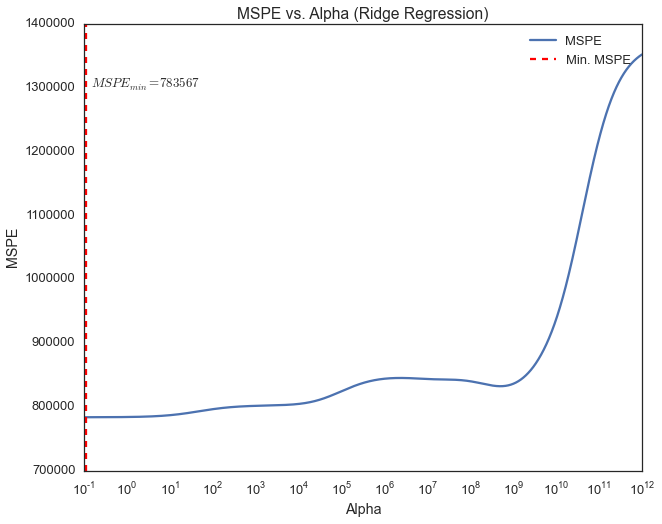

In [117]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(alphas, mspes, label="MSPE")
ax.axvline(x=alphas[mspes.argmin()] + 0.01,
           c='r', linestyle='dashed',
           label="Min. MSPE")
ax.set_xscale('log')
plt.legend(loc="upper right")
ax.text(alphas[mspes.argmin()] + 0.05,
        1300000,
        r"$MSPE_{{min}} = {:.0f}$".format(mspes.min()),
        fontsize=13)
plt.title("MSPE vs. Alpha (Ridge Regression)")
plt.xlabel("Alpha")
plt.ylabel("MSPE")
plt.show()

In [118]:
ridge_coeffs_auto_solv = coeffs[mspes.argmin()]
ridge_mspe_auto_solv = mspes.min()
ridge_model_auto_solv = models[mspes.argmin()]

In [119]:
results = {'Ridge Coeff Auto Solv.': pd.Series(ridge_coeffs,
                index=cols),
           'Lasso Coeff': pd.Series(lasso_coeffs, index=cols),
           'Elastic Net': pd.Series(enet_coeffs, index=cols),
           'Ridge Coeff LSQR Solv.':
               pd.Series(ridge_coeffs_auto_solv,
               index=cols)}
df = pd.DataFrame(results)
print df

             Elastic Net  Lasso Coeff  Ridge Coeff Auto Solv.  \
_intercept   1606.440751  1558.713718             2603.458933   
private        77.365144   131.010475                0.000013   
apps            0.084098     0.085193                0.049081   
accept         -0.035267    -0.037033                0.012659   
enroll         -0.247173    -0.245687               -0.022591   
top10perc      -9.822516    -9.873752               -0.001011   
top25perc       1.719845     1.729894               -0.000725   
f_undergrad    -0.006667    -0.004805               -0.038710   
p_undergrad     0.096722     0.097007                0.063245   
outstate        0.152051     0.149229                0.142297   
books           0.691125     0.687762                0.021222   
personal       -0.110428    -0.111550               -0.026266   
phd            -1.156684    -0.902008                0.000459   
terminal        8.713771     8.878668                0.001023   
s_f_ratio      -3.074226 

Notice how the coefficients change drastically depending on the *solver* parameter.

#### MSPES

In [120]:
print "Elastic Net: {}".format(enet_mspe)
print "Lasso: {}".format(lasso_mspe)
print "Ridge Auto Solve: {}".format(ridge_mspe_auto_solv)
print "Ridge LSQR Solve: {}".format(ridge_mspe)

Elastic Net: 790936.633461
Lasso: 783707.145415
Ridge Auto Solve: 783566.885238
Ridge LSQR Solve: 832229.510418


#### Alternative Computational Functions for Regression

Another way of implementing all of these is with scikit-learn's built-in regression cross-validation functions. This is in contrast to finding minimum MSPE's, as was done above.

In [121]:
# Ridge
clf = linear_model.RidgeCV(alphas=alphas)
clf.fit(X_train, y_train)
ridge_params = np.concatenate((np.array([clf.intercept_]), clf.coef_))
y_pred_test = clf.predict(X_test)
ridge_mspe = mean_squared_error(y_test, y_pred_test)

In [122]:
# Lasso
clf = linear_model.LassoCV(n_alphas=1000)
clf.fit(X_train, y_train)
lasso_params = np.concatenate((np.array([clf.intercept_]), clf.coef_))
y_pred_test = clf.predict(X_test)
lasso_mspe = mean_squared_error(y_test, y_pred_test)

In [123]:
# Elastic Net
# Note the L1 ratio function parameter
clf = linear_model.ElasticNetCV(n_alphas=1000, l1_ratio=0.5)
clf.fit(X_train, y_train)
enet_params = np.concatenate((np.array([clf.intercept_]), clf.coef_))
y_pred_test = clf.predict(X_test)
enet_mspe = mean_squared_error(y_test, y_pred_test)

In [124]:
results = {'Ridge Coeff': pd.Series(ridge_params, index=cols),
           'Lasso Coeff': pd.Series(lasso_params, index=cols),
           'Elastic Net': pd.Series(enet_params, index=cols)}
df = pd.DataFrame(results)
print df

             Elastic Net  Lasso Coeff  Ridge Coeff
_intercept   2377.929982  2353.628217  1734.431098
private         0.000000     0.000000     0.581423
apps            0.067446     0.067950     0.078950
accept          0.008462     0.006171    -0.021332
enroll         -0.208413    -0.208263    -0.271626
top10perc      -0.000000    -0.000000    -7.186482
top25perc      -0.000000    -0.000000     0.055822
f_undergrad    -0.021486    -0.020696    -0.007743
p_undergrad     0.113068     0.111833     0.099170
outstate        0.155037     0.155319     0.155781
books           0.436392     0.483483     0.716551
personal       -0.078567    -0.078517    -0.107419
phd             0.000000     0.000000    -0.389059
terminal        0.000000     0.000000     6.588104
s_f_ratio       0.000000     0.000000    -1.249269
perc_alumni    -0.000000    -0.000000    -9.413837
expend          0.016435     0.016081     0.023339
grad_rate       0.000000     0.000000     6.337188


In [125]:
print "Elastic Net MSPE: {}".format(enet_mspe)
print "Lasso MSPE: {}".format(lasso_mspe)
print "Ridge MPSE: {}".format(ridge_mspe)

Elastic Net MSPE: 842392.722943
Lasso MSPE: 842849.151465
Ridge MPSE: 804294.570132


Let's use these latest models for comparison rather than the previous ones since here Lasso and Elastic Net actually eliminate parameters. This should be a more interesting comparison.

I prefer the Ridge model. We don't have p >> n so we don't really need to eliminate parameters with Lasso or Elastic Net. We also have an ill-conditioned problem (colinearity), so perhaps Ridge is appropriate here. Ridge also results in the lowest MSPE. But what is most compelling about Ridge is that it didn't eliminate the *private* parameter, like Elastic Net and Lasso did. I would posit that room and board at most private universities is more expensive than at public universities.

However, the previous models (look two tables above) are quite comparable to each other. There, it would seem to make sense that the coefficient for being a private school or not is quite high, since private schools can be quite expensive in general. However, it doesn't seem to make sense that the coefficient for *Percent new students from top 10% of H.S. class* is significantly negative and then *Percent new students from top 25% of H.S. class* is positive. I'm having trouble justifying how that could influence room and board costs.

All the models offer some degree of interpretability, they're reasonably close in MSPE (and therefore reasonably close in prediction accuracy).